# Projet Datascientest - Compagnon immo

<code>mar25_bds_compagnon_immo_1</code>


---

## Modélisation évolution des prix - v2.0

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip

from tabulate import tabulate

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

<div class="alert alert-info">
<i class="fa fa-info-circle"></i> Pour les premières analyses et les premiers tests de modèles nous travaillerons que sur un seul département.
</div>

### Chargement des données

In [111]:
output_path_dep_75 = '../data/raw/dep_75.csv.gz'

if os.path.exists(output_path_dep_75):
    with gzip.open(output_path_dep_75, 'rt', encoding='utf-8') as file:
        print("Le fichier existe déjà. Chargement du dataFrame...")
        df_dep75 = pd.read_csv(file, low_memory=False, index_col='date_mutation', parse_dates=True)
        print("DataFrame chargé.")
else:
    print("Création du dataframe pour dep 75...")
    output_path = f"../data/raw/full_years_merged.csv.gz"
    dvf_df = pd.read_csv(output_path, low_memory=False, index_col="date_mutation")
    
    df_dep75 = dvf_df[dvf_df['code_departement'] == 75]
    df_dep75.to_csv(output_path_dep_75, compression='gzip')
    print("Création du dataframe pour dep 75 terminé")
    del dvf_df

Le fichier existe déjà. Chargement du dataFrame...
DataFrame chargé.


In [26]:
display(df_dep75.head())

display(df_dep75.shape)

,id_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
date_mutation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,2020-1426687,1,Vente,268800.0,14.0,NaN,RUE DE L ARCADE,0411,75008.0,75108,Paris 8e Arrondissement,75,NaN,NaN,75108000BS0136,NaN,NaN,31,NaN,8,22.72,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,24.0,1.0,NaN,NaN,NaN,NaN,NaN,2.323937,48.871607
2020-01-06,2020-1426688,1,Vente,878378.0,9.0,NaN,BD DE LA MADELEINE,5888,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000BC0041,NaN,NaN,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4.0,Local industriel. commercial ou assimilé,43.0,0.0,NaN,NaN,NaN,NaN,NaN,2.326882,48.869331
2020-01-06,2020-1426688,1,Vente,878378.0,9.0,NaN,BD DE LA MADELEINE,5888,75001.0,75101,Paris 1er Arrondissement,75,NaN,NaN,75101000BC0041,NaN,NaN,14,66.64,15,NaN,40.0,NaN,NaN,NaN,NaN,NaN,3,2.0,Appartement,66.0,2.0,NaN,NaN,NaN,NaN,NaN,2.326882,48.869331
2020-01-10,2020-1426689,1,Vente,680000.0,10.0,NaN,RUE DU BOURG L ABBE,1200,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AV0006,NaN,NaN,9,50.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,51.0,2.0,NaN,NaN,NaN,NaN,NaN,2.351965,48.864157
2020-01-03,2020-1426690,1,Vente,852000.0,24.0,NaN,RUE DE SAINTONGE,8716,75003.0,75103,Paris 3e Arrondissement,75,NaN,NaN,75103000AK0080,NaN,NaN,74,66.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.0,Appartement,12.0,1.0,NaN,NaN,NaN,NaN,NaN,2.363196,48.862017


(389586, 39)

### Nettoyage et pre-processing des données

In [11]:
def create_target(df):
    # Supprimer les valeurs foncières manquantes et les surfaces à 0
    df = df.dropna(subset=['valeur_fonciere'])
    df = df[(df['surface_reelle_bati'].notna()) | (df['surface_terrain'].notna())]
    df = df[(df['surface_reelle_bati'] > 0) | (df['surface_terrain'] > 0)]
    
    # Créer la target "prix_m2_vente"
    df['prix_m2_vente'] = np.where(
        (df['surface_reelle_bati'].notna()) & (df['surface_reelle_bati'] > 0),
        df['valeur_fonciere'] / df['surface_reelle_bati'],
        np.where(
            (df['surface_terrain'].notna()) & (df['surface_terrain'] > 0),
            df['valeur_fonciere'] / df['surface_terrain'],
            np.nan
        )
    )
    return df

def remove_outliers(df):
    # Filtrer selon les valeurs de prix au m²
    df = df[(df['prix_m2_vente'] > 10) & (df['prix_m2_vente'] < 50_000_000)]
    # Filtrer selon la valeur foncière
    df = df[(df['valeur_fonciere'] > 10) & (df['valeur_fonciere'] < 500_000_000)]
    # Filtrer selon la surface du terrain
    df = df[df['surface_terrain'] < 1_000_000]
    return df

def remove_duplicates(df):
    return df.drop_duplicates()

def drop_unused_columns(df, cols_to_drop):
    return df.drop(cols_to_drop, axis=1)

def process_dates(df):
    df['annee'] = df.index.year
    df['mois'] = df.index.month
    return df

def enrich_with_insee_data(df, url_insee):
    """Ajout des données INSEE : latitude et longitude."""
    df_insee = pd.read_csv(url_insee, sep=';')
    df_insee[['latitude', 'longitude']] = df_insee['coordonnees_gps'].str.split(',', expand=True)
    latitude_dict = df_insee.set_index('Code_commune_INSEE')['latitude'].to_dict()
    longitude_dict = df_insee.set_index('Code_commune_INSEE')['longitude'].to_dict()
    df['latitude'] = df['latitude'].fillna(df['code_commune'].map(latitude_dict)).astype('float')
    df['longitude'] = df['longitude'].fillna(df['code_commune'].map(longitude_dict)).astype('float')
    df = df.dropna(subset=['latitude', 'longitude'])
    del df_insee
    return df

def handle_missing_values(df):
    # Code type local
    df.loc[(df['code_type_local'].isna()) & (df['type_local'] == 'Maison'), 'code_type_local'] = 1.0
    df.loc[(df['code_type_local'].isna()) & (df['type_local'] == 'Appartement'), 'code_type_local'] = 2.0
    df.loc[(df['code_type_local'].isna()) & (df['type_local'] == 'Dépendance'), 'code_type_local'] = 3.0
    df.loc[(df['code_type_local'].isna()) & (df['type_local'] == 'Local industriel. commercial ou assimilé'), 'code_type_local'] = 4.0
    df.loc[(df['code_type_local'].isna()), 'code_type_local'] = 5.0

    # Type local
    df.loc[(df['type_local'].isna()) & (df['code_type_local'] == 1.0), 'type_local'] = 'Maison'
    df.loc[(df['type_local'].isna()) & (df['code_type_local'] == 2.0), 'type_local'] = 'Appartement'
    df.loc[(df['type_local'].isna()) & (df['code_type_local'] == 3.0), 'type_local'] = 'Dépendance'
    df.loc[(df['type_local'].isna()) & (df['code_type_local'] == 4.0), 'type_local'] = 'Local industriel. commercial ou assimilé'
    df.loc[(df['type_local'].isna()), 'type_local'] = 'Autre'

    # Autres colonnes avec des valeurs manquantes
    df['surface_reelle_bati'] = df['surface_reelle_bati'].fillna(0)
    df['nombre_pieces_principales'] = df['nombre_pieces_principales'].fillna(0)
    df['surface_terrain'] = df['surface_terrain'].fillna(0)
    df['code_nature_culture'] = df['code_nature_culture'].fillna('NS')
    df['nature_culture'] = df['nature_culture'].fillna('autres')
    df['code_nature_culture_speciale'] = df['code_nature_culture_speciale'].fillna('NS')
    df['nature_culture_speciale'] = df['nature_culture_speciale'].fillna('Autre')

    # Colonnes lot
    for col in ['lot1_surface_carrez', 'lot2_surface_carrez', 'lot3_surface_carrez',
                'lot4_surface_carrez', 'lot5_surface_carrez',
                'lot1_numero', 'lot2_numero', 'lot3_numero', 'lot4_numero', 'lot5_numero']:
        df[col] = df[col].fillna(0)

    df.loc[df['nombre_lots'].isna(), 'nombre_lots'] = 0

    # on a les codes correspondants
    df = df.drop(['nature_culture_speciale', 'nature_culture'], axis=1)
    
    return df

def check_dataframe(df):
    data = [
        ["Taille du dataframe :", f"{df.shape[0]} lignes et {df.shape[1]} colonnes"],
        ["Valeurs manquantes après traitement :", f"{round((df.isna().sum().sum() / df.size) * 100, 2)}%"],
        ["Doublons après traitement :", f"{df.duplicated().sum() / len(df) * 100:.2f}%"],
        ["Target manquante :", df['prix_m2_vente'].isna().sum()],
    ]
    print(tabulate(data, headers=["Description", "Value"], tablefmt="grid"))


def preprocess_dataframe(df):
    df = create_target(df)
    df = remove_outliers(df)
    df = drop_unused_columns(df, [
        'id_mutation', 'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle', 
        'id_parcelle', 'numero_volume', 'adresse_suffixe', 'adresse_numero', 
        'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'nom_commune'
    ])
    df = process_dates(df)
    df = handle_missing_values(df)
    df = remove_duplicates(df)
    check_dataframe(df)
    return df

In [32]:
url_insee = 'https://raw.githubusercontent.com/klopstock-dviz/immo_vis/master/data/codesPostaux_communesINSEE.csv'
df_dep75 = enrich_with_insee_data(df_dep75, url_insee)
df_dep75 = preprocess_dataframe(df_dep75)

+---------------------------------------+-----------------------------+
| Description                           | Value                       |
+=======================================+=============================+
| Taille du dataframe :                 | 15212 lignes et 28 colonnes |
+---------------------------------------+-----------------------------+
| Valeurs manquantes après traitement : | 0.0%                        |
+---------------------------------------+-----------------------------+
| Doublons après traitement :           | 0.00%                       |
+---------------------------------------+-----------------------------+
| Target manquante :                    | 0                           |
+---------------------------------------+-----------------------------+


### Checkpoint

In [210]:
display(df_dep75.shape)
# Dump le dataset clean
output_path = '../data/processed/dep_75_cleaned.csv.gz'
df_dep75.to_csv(output_path, index='date_mutation', compression='gzip')
print("Le dataframe nettoyé a été sauvegardé.")

(15212, 28)

Le dataframe nettoyé a été sauvegardé.


In [135]:
output_path = '../data/processed/dep_75_cleaned.csv.gz'
df_dep75 = pd.read_csv(output_path, low_memory=False, index_col='date_mutation', parse_dates=True)

### Analyse de la série temporelle

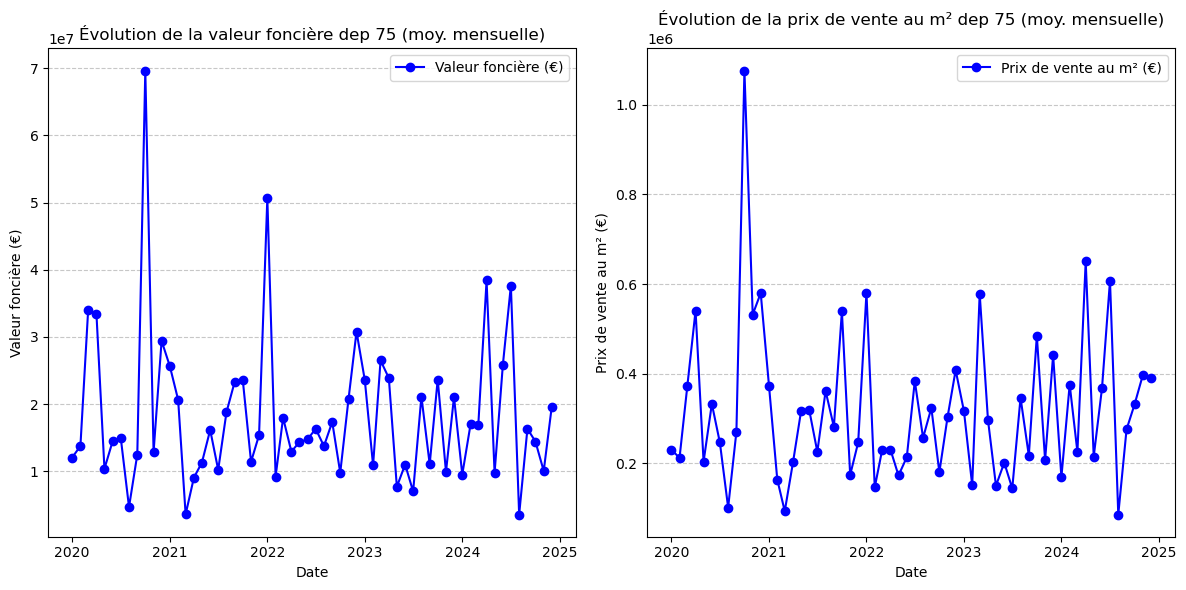

In [117]:
df_monthly = df_dep75.select_dtypes(include='number').resample('MS').mean()

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(df_monthly.index, df_monthly['valeur_fonciere'], color='b', marker='o', label='Valeur foncière (€)')
plt.title("Évolution de la valeur foncière dep 75 (moy. mensuelle)")
plt.xlabel("Date")
plt.ylabel("Valeur foncière (€)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(122)
plt.plot(df_monthly.index, df_monthly['prix_m2_vente'], color='b', marker='o', label='Prix de vente au m² (€)')
plt.title("Évolution de la prix de vente au m² dep 75 (moy. mensuelle)")
plt.xlabel("Date")
plt.ylabel("Prix de vente au m² (€)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show();

#### Recherche du type de la série

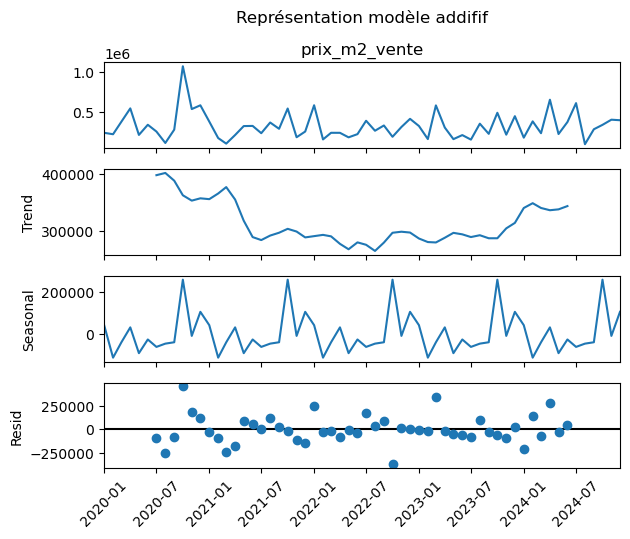

In [206]:
result = seasonal_decompose(df_monthly['prix_m2_vente'], period=12)
result.plot()
plt.xticks(rotation=45)
plt.title('Représentation modèle addifif', y=5.1)
plt.show();

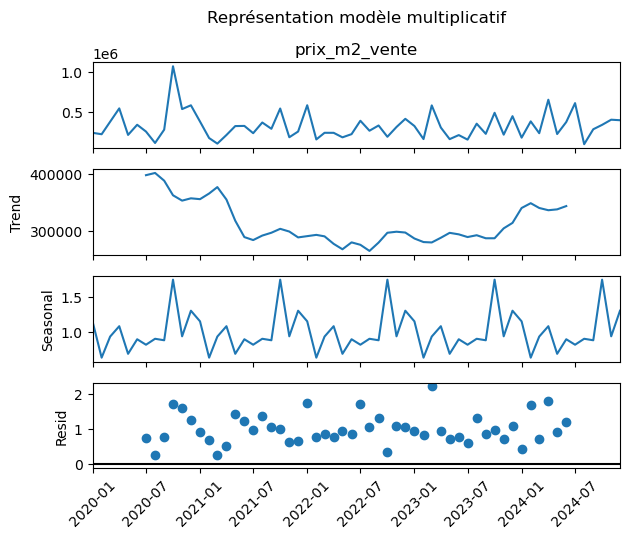

In [64]:
result = seasonal_decompose(df_monthly['prix_m2_vente'], model='multiplicative', period=12)
result.plot()
plt.xticks(rotation=45)
plt.title('Représentation modèle multiplicatif', y=5.1)
plt.show();

In [74]:
decomposition_additive = seasonal_decompose(df_monthly['prix_m2_vente'], period=12)
decomposition_multiplicative = seasonal_decompose(df_monthly['prix_m2_vente'], model='multiplicative', period=12)

# Résidus pour les deux modèles
resid_add = decomposition_additive.resid.dropna()
resid_mult = decomposition_multiplicative.resid.dropna()

# Calcul l'écart-type des résidus
std_add = resid_add.std()
std_mult = resid_mult.std()
serie_type = 'additif' if std_add < std_mult else 'multiplicatif'

data = [
    ["Écart-type des résidus (Additif)", std_add],
    ["Écart-type des résidus (Multiplicatif) :", std_mult],
    ["Type de la série :", serie_type],
]
print(tabulate(data, headers=["Description", "Value"], tablefmt="grid"))

+------------------------------------------+--------------------+
| Description                              | Value              |
+==========================================+====================+
| Écart-type des résidus (Additif)         | 149694.7861990037  |
+------------------------------------------+--------------------+
| Écart-type des résidus (Multiplicatif) : | 0.4201868799231329 |
+------------------------------------------+--------------------+
| Type de la série :                       | multiplicatif      |
+------------------------------------------+--------------------+


#### Transformation logarithmique

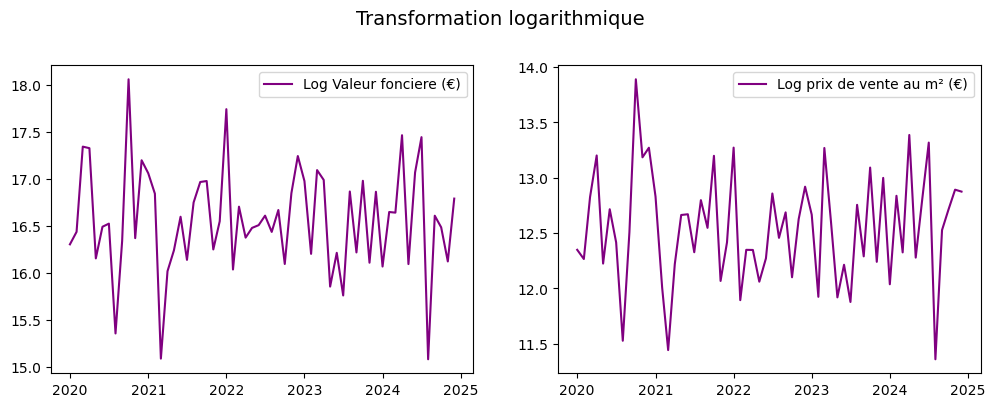

In [119]:
df_monthly = df_dep75.select_dtypes(include='number').resample('MS').mean()
df_monthly['log_valeur_fonciere'] = np.log(df_monthly['valeur_fonciere'])
df_monthly['log_prix_m2_vente'] = np.log(df_monthly['prix_m2_vente'])

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(df_monthly.index, df_monthly['log_valeur_fonciere'], color='purple', label='Log Valeur fonciere (€)')
plt.legend()

plt.subplot(122)
plt.plot(df_monthly.index, df_monthly['log_prix_m2_vente'], color='purple', label='Log prix de vente au m² (€)')
plt.legend()

plt.suptitle("Transformation logarithmique", fontsize=14, y=1.02)
plt.show();

#### Vérification stationnarité

In [9]:
_, p_value, _, _, _, _  = adfuller(df_monthly['log_prix_m2_vente'])

res = 'stationnaire' if p_value < 0.05  else 'non stationnaire'
data = [
    ["p_value test Dickey-Fuller", p_value],
    ["Résultat", res],
]
print(tabulate(data, headers=["Description", "Value"], tablefmt="grid"))

+----------------------------+----------------------+
| Description                | Value                |
+============================+======================+
| p_value test Dickey-Fuller | 7.52124410399033e-12 |
+----------------------------+----------------------+
| Résultat                   | stationnaire         |
+----------------------------+----------------------+


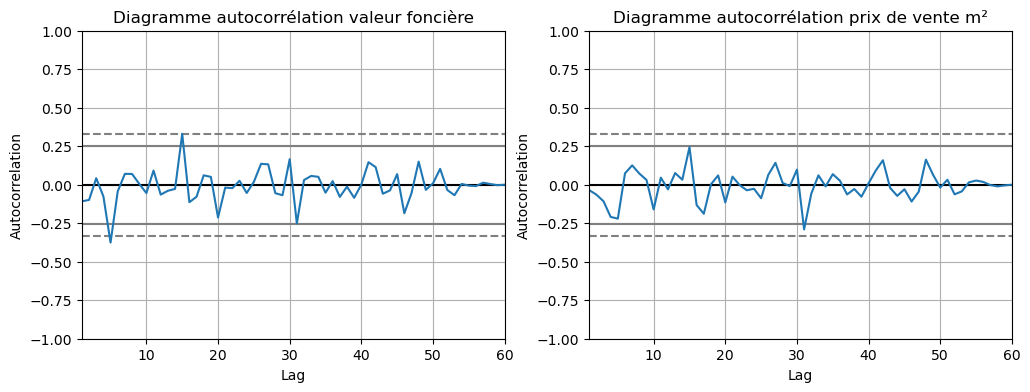

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
pd.plotting.autocorrelation_plot(df_monthly['log_valeur_fonciere'])
plt.title("Diagramme autocorrélation valeur foncière")

plt.subplot(122)
pd.plotting.autocorrelation_plot(df_monthly['log_prix_m2_vente'])
plt.title("Diagramme autocorrélation prix de vente m²")

plt.show();

#### Vérification saisonnalité

##### PAF et PACF

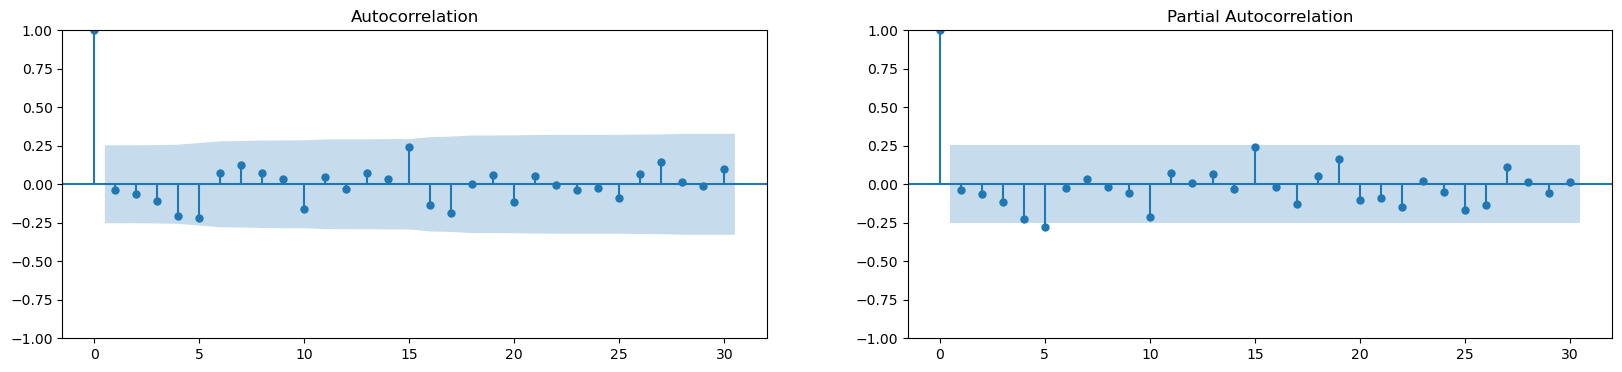

In [119]:
max_lags = min(48, len(df_monthly) // 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
plot_acf(df_monthly['log_prix_m2_vente'], lags=max_lags, ax=ax1)
plot_pacf(df_monthly['log_prix_m2_vente'], lags=max_lags, ax=ax2)
plt.show();

##### Test de Ljung-Box

In [71]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags = [6, 12, 24]
ljung_box_result = acorr_ljungbox(df_monthly["log_prix_m2_vente"].dropna(), lags=lags, return_df=True)

for lag in lags:
    ljung_box_result.loc[lag, "saisonnalite"] = ljung_box_result["lb_pvalue"].loc[lag] < 0.05

ljung_box_result

,lb_stat,lb_pvalue,saisonnalite
6,7.657163,0.264311,False
12,11.367912,0.497679,False
24,23.424237,0.494884,False


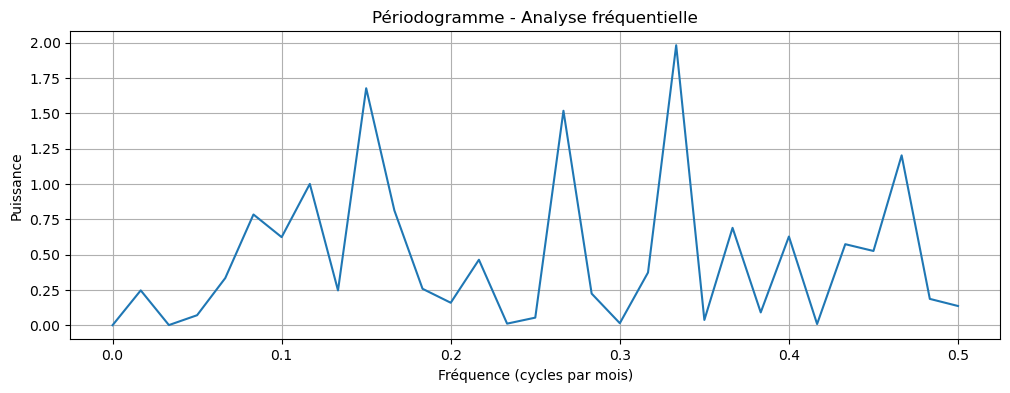

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram

serie = df_monthly['log_prix_m2_vente'].dropna()
frequencies, power = periodogram(serie)

plt.figure(figsize=(12, 4))
plt.plot(frequencies, power)
plt.title("Périodogramme - Analyse fréquentielle")
plt.xlabel("Fréquence (cycles par mois)")
plt.ylabel("Puissance")
plt.grid(True)
plt.show();

### Tests de modèles

#### Premières modélisations

In [137]:
train = df_monthly[df_monthly['annee'] < 2024]
test = df_monthly[df_monthly['annee'] == 2024]

X_train = train.drop(['valeur_fonciere', 'log_valeur_fonciere'], axis=1)
X_test = test.drop(['valeur_fonciere', 'log_valeur_fonciere'], axis=1)

y_train_log = train['log_valeur_fonciere']
y_test_log = test['log_valeur_fonciere']

In [139]:
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [141]:
# 1ere approche
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train_log)

LinearRegression()

In [143]:
joblib.dump(linreg, "../models/model_regression_lineaire_time_series.pkl")
print("Modèle sauvegardé avec succès.")

Modèle sauvegardé avec succès.


In [147]:
y_pred_log = linreg.predict(X_test_scaled)

y_pred = np.exp(y_pred_log)
y_test = np.exp(y_test_log)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

scores = [{"Modèle": "LinearRegression", "MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}]

pd.DataFrame(scores)

,Modèle,MAE,MSE,RMSE,R²
0,LinearRegression,4.177914e+06,2.677424e+13,5.174383e+06,0.752115


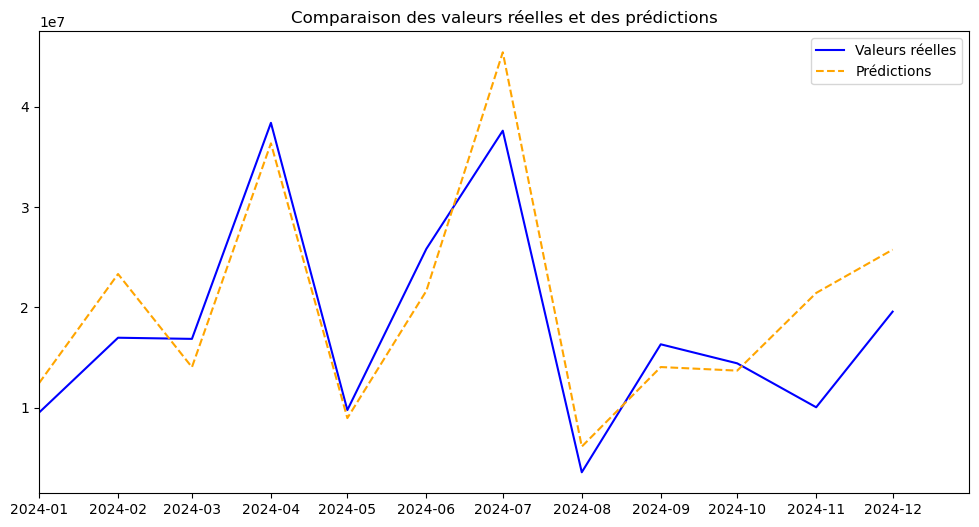

In [149]:
y_pred = pd.Series(y_pred, index=y_test.index)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Valeurs réelles', color='blue')
plt.plot(y_pred, label='Prédictions', color='orange', linestyle='--')
plt.title("Comparaison des valeurs réelles et des prédictions")
plt.xlim(pd.Timestamp('2024-01-01'), pd.Timestamp('2024-12-31'))
plt.legend()
plt.show();

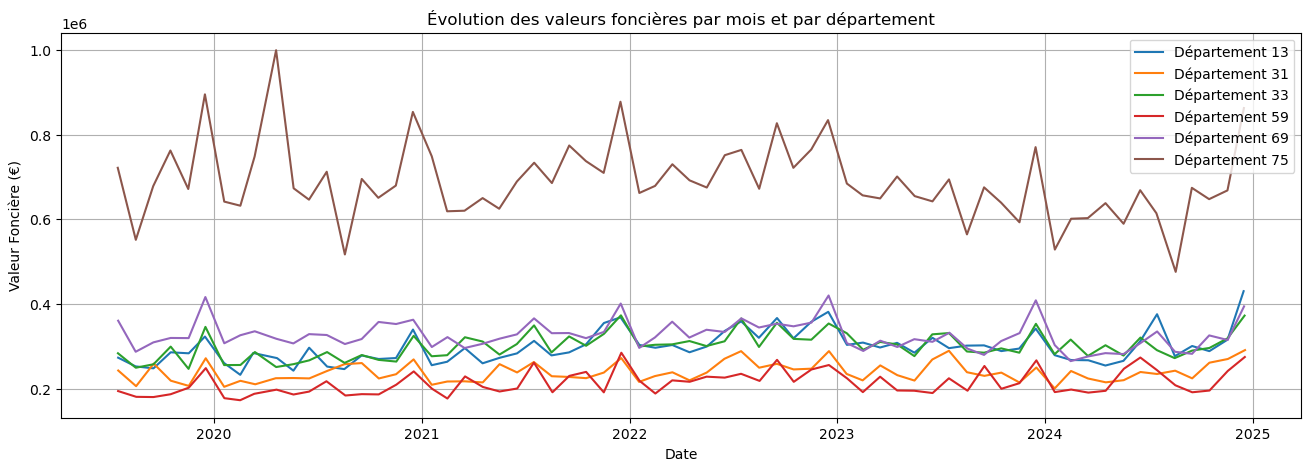

In [46]:
dvf_df['date_mutation'] = pd.to_datetime(dvf_df.index)
df_dep = dvf_df.groupby(['code_departement']).resample('MS').mean()

# Visualisation sur les départements les plus peuplés
top_deps = [13, 31, 33, 59, 69, 75]

plt.figure(figsize=(16, 5))
for dep in top_deps:
    dep_data = df_dep[df_dep['code_departement'] == dep]
    plt.plot(dep_data['date_mutation'], dep_data['valeur_fonciere'], label=f"Département {dep}")

plt.title("Évolution des valeurs foncières par mois et par département")
plt.xlabel("Date")
plt.ylabel("Valeur Foncière (€)")
plt.legend()
plt.grid(True)
plt.show();

#### ARIMA

In [121]:
df_train = df_monthly[df_monthly.index.year < 2024]
df_test = df_monthly[df_monthly.index.year == 2024]

def train_arima(df_train, order):
    model_arima = ARIMA(df_train["log_prix_m2_vente"], order=order)
    arima_model = model_arima.fit()
    print(arima_model.summary())
    return arima_model

def forecast_arima(model, df_test, year):
    forecast = model.get_forecast(steps=len(df_test))
    y_pred = forecast.predicted_mean
    conf_int = forecast.conf_int()
    return y_pred, conf_int

def plot_forecast(df_test, y_pred, conf_int, year):
    future_index = df_test.index

    plt.figure(figsize=(10, 5))
    plt.plot(df_test.index, df_test["log_prix_m2_vente"], label=f"Valeurs réelles ({year})", marker="o")
    plt.plot(future_index, y_pred, label=f"Prédictions ARIMA ({year})", linestyle="dashed", marker="x")
    
    # Affichage de l'intervalle de confiance
    plt.fill_between(future_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="gray", alpha=0.2)

    plt.legend()
    plt.title(f"Comparaison des prix réels vs prédits ({year})")
    plt.xticks(rotation=45)
    
    plt.xlim(pd.to_datetime([f"{year}-01-01", f"{year}-12-31"]))
    plt.show();

def evaluate_forecast(df_test, y_pred, order):
    model = 'ARIMA'
    model_scores = [{
        "Modèle": model,
        "Order": order,
        "MAE": mean_absolute_error(df_test["log_prix_m2_vente"], y_pred),
        "RMSE": np.sqrt(mean_squared_error(df_test["log_prix_m2_vente"], y_pred)),
        "R2": r2_score(df_test["log_prix_m2_vente"], y_pred)
    }]

    df_scores = pd.DataFrame(model_scores)
    print(f"[Résultat {model}]")
    display(df_scores)

def test_stationarity(model):
    residuals = model.resid
    adf_test = adfuller(residuals)
    print('[Vérification résidus]')
    data = [{
        'Statistique ADF' : f"{adf_test[0]:.3f}",
        'P-value' : f"{adf_test[1]:.3f}",
        'Résultat' : 'stationnaire' if adf_test[1] < 0.05 else 'non stationnaire'
    }]
    display(pd.DataFrame(data))

def plt_by_year(model, df_test):
    pred = model.get_forecast(steps=len(df_test))
    pred_df = pred.summary_frame()
    pred_df = np.exp(pred_df)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df_monthly.index, df_monthly['prix_m2_vente'], label="Historique")
    pred_df['mean'].plot(ax=ax, style='--', label="Prévision")
    ax.fill_between(pred_df.index, pred_df['mean_ci_lower'], pred_df['mean_ci_upper'], color='gray', alpha=0.3)
    ax.legend()
    plt.title("Prévision ARIMA sur le prix/m²")
    plt.show();

def train_and_evaluate_arima(df_train, df_test, order, year):
    model = train_arima(df_train, order)
    y_pred, conf_int = forecast_arima(model, df_test, year)
    plot_forecast(df_test, y_pred, conf_int, year)
    evaluate_forecast(df_test, y_pred, order)
    test_stationarity(model)
    plt_by_year(model, df_test)

                               SARIMAX Results                                
Dep. Variable:      log_prix_m2_vente   No. Observations:                   48
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -34.921
Date:                Sun, 04 May 2025   AIC                             77.842
Time:                        13:15:22   BIC                             85.242
Sample:                    01-01-2020   HQIC                            80.627
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1077      0.174      0.621      0.535      -0.232       0.448
ar.L2         -0.0948      0.145     -0.656      0.512      -0.378       0.189
ma.L1         -0.9991      5.710     -0.175      0.8

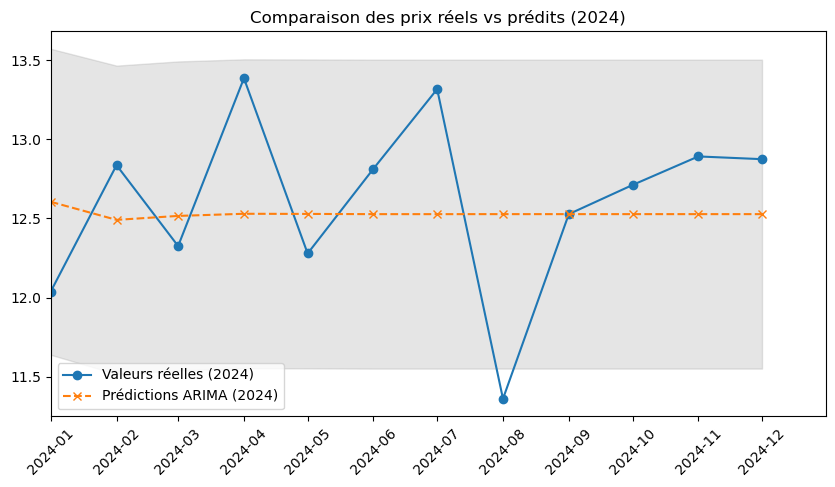

[Résultat ARIMA]


,Modèle,Order,MAE,RMSE,R2
0,ARIMA,"(2, 1, 1)",0.44571,0.549795,-0.054587


[Vérification résidus]


,Statistique ADF,P-value,Résultat
0,-4.256,0.001,stationnaire


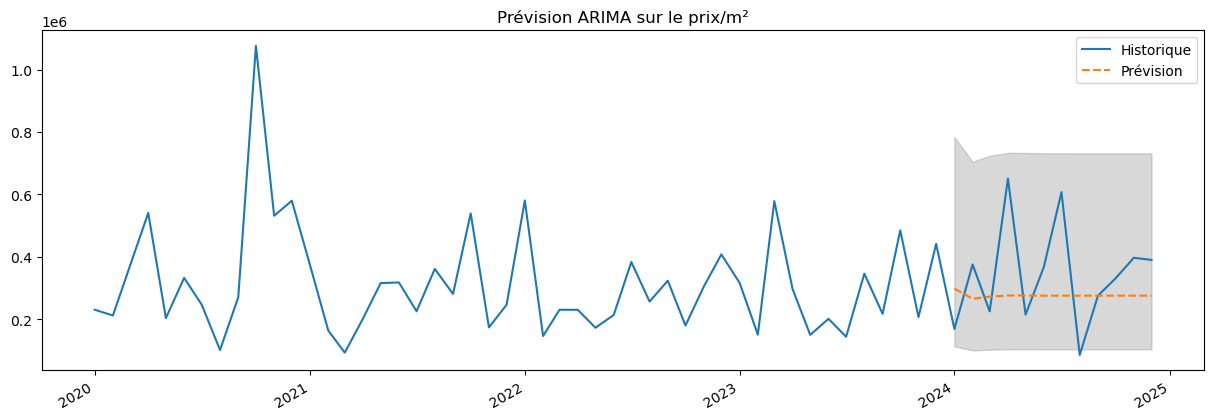

In [178]:
train_and_evaluate_arima(df_train, df_test, order=(2,1,1), year='2024')

In [209]:
df_scores = pd.DataFrame(scores)
df_scores

,Modèle,MAE,MSE,RMSE,R²
0,LinearRegression,19545.327001,5.843703e+08,24173.75221,-0.457691


#### Regroupement par département

#### Optimisations ARIMA

In [170]:
import itertools
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Initialisation des valeurs optimales
best_aic = float("inf")
best_params = None

for param in pdq:
    try:
        mod = ARIMA(df_monthly["log_prix_m2_vente"], order=param)
        results = mod.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
    except:
        continue

data = [
    ["Meilleurs paramètres ARIMA :", best_params],
    ["Meilleur AIC :", best_aic],
]
print(tabulate(data, headers=["Description", "Value"], tablefmt="grid"))

+------------------------------+-------------------+
| Description                  | Value             |
+==============================+===================+
| Meilleurs paramètres ARIMA : | (1, 0, 1)         |
+------------------------------+-------------------+
| Meilleur AIC :               | 89.01098130259354 |
+------------------------------+-------------------+


                               SARIMAX Results                                
Dep. Variable:      log_prix_m2_vente   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -33.344
Date:                Sun, 04 May 2025   AIC                             74.689
Time:                        13:15:48   BIC                             82.174
Sample:                    01-01-2020   HQIC                            77.517
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5274      0.077    161.702      0.000      12.376      12.679
ar.L1         -0.3893      1.088     -0.358      0.721      -2.522       1.744
ma.L1          0.4934      1.042      0.473      0.6

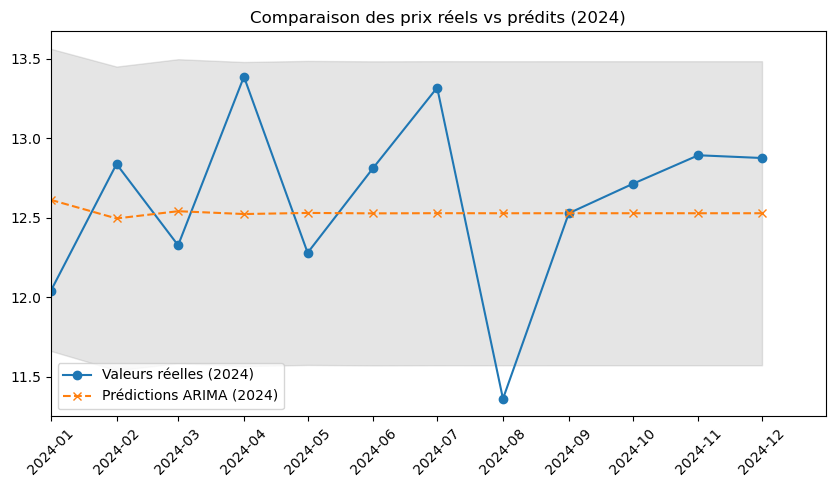

[Résultat ARIMA]


,Modèle,Order,MAE,RMSE,R2
0,ARIMA,"(1, 0, 1)",0.448625,0.551821,-0.062373


[Vérification résidus]


,Statistique ADF,P-value,Résultat
0,-6.711,0.000,stationnaire


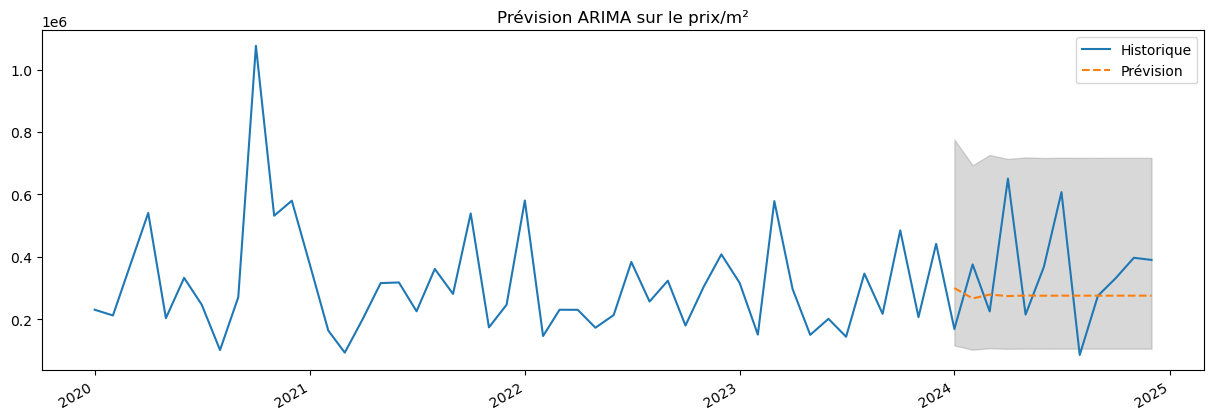

In [180]:
train_and_evaluate_arima(df_train, df_test, order=(best_params), year='2024')

                               SARIMAX Results                                
Dep. Variable:      log_prix_m2_vente   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -34.647
Date:                Sun, 04 May 2025   AIC                             79.294
Time:                        13:15:59   BIC                             88.545
Sample:                    01-01-2020   HQIC                            82.775
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8415      0.218     -3.865      0.000      -1.268      -0.415
ar.L2          0.0446      0.190      0.235      0.814      -0.328       0.417
ma.L1         -0.0011   9028.040  -1.17e-07      1.0

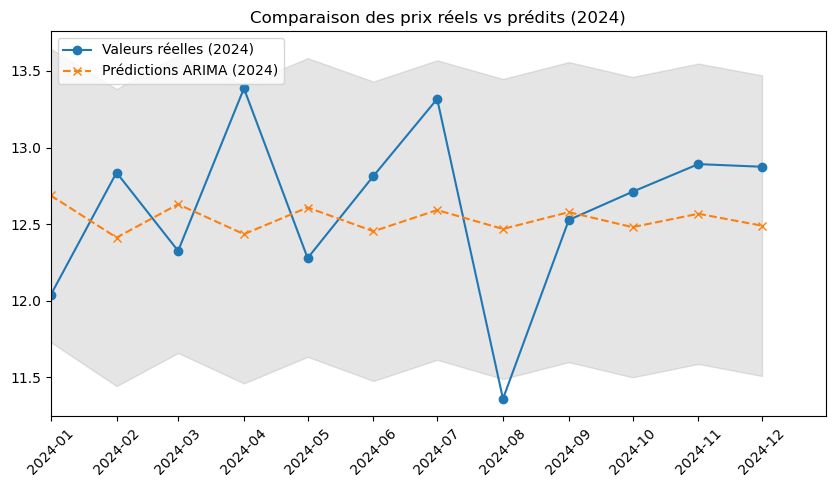

[Résultat ARIMA]


,Modèle,Order,MAE,RMSE,R2
0,ARIMA,"(2, 1, 2)",0.486898,0.57003,-0.133643


[Vérification résidus]


,Statistique ADF,P-value,Résultat
0,-4.246,0.001,stationnaire


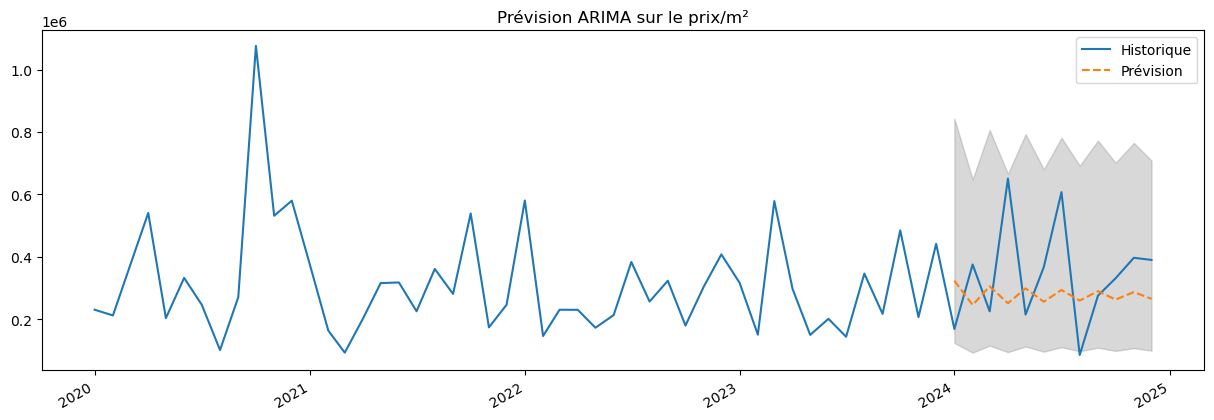

In [182]:
# Paramètres alternatifs
train_and_evaluate_arima(df_train, df_test, order=(2,1,2), year='2024')

### Autres modèles

14:50:00 - cmdstanpy - INFO - Chain [1] start processing
14:50:00 - cmdstanpy - INFO - Chain [1] done processing


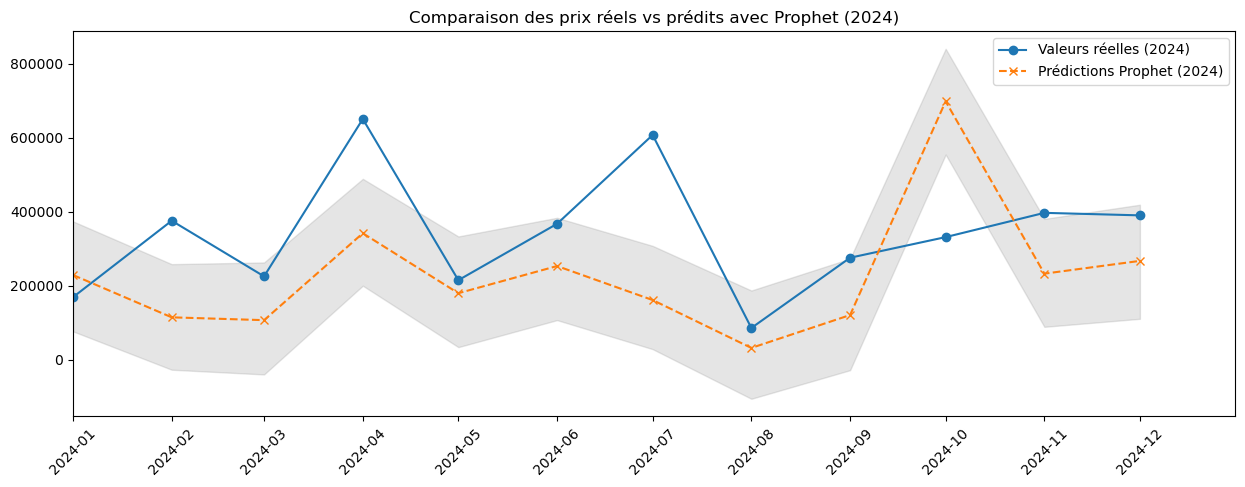

MAE: 183908.40, RMSE: 223254.16, R²: -0.98


In [256]:
df_prophet = df_monthly.reset_index()[['date_mutation', 'prix_m2_vente']].rename(
    columns={'date_mutation': 'ds', 'prix_m2_vente': 'y'}
)

df_train = df_prophet[df_prophet["ds"].dt.year < 2024]
df_test = df_prophet[df_prophet["ds"].dt.year == 2024]

model_prophet = Prophet()
model_prophet.fit(df_train)

future_dates = model_prophet.make_future_dataframe(periods=12, freq="MS")
forecast = model_prophet.predict(future_dates)

forecast_2024 = forecast[forecast["ds"].dt.year == 2024]

plt.figure(figsize=(15, 5))

# Valeurs réelles
plt.plot(df_test["ds"], df_test["y"], label="Valeurs réelles (2024)", marker="o")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
# Prédictions Prophet
plt.plot(forecast_2024["ds"], forecast_2024["yhat"], label="Prédictions Prophet (2024)", linestyle="dashed", marker="x")

# Intervalle de confiance
plt.fill_between(forecast_2024["ds"], forecast_2024["yhat_lower"], forecast_2024["yhat_upper"], color="gray", alpha=0.2)
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec Prophet (2024)")
plt.xticks(rotation=45)
plt.show();
# Comparaison entre valeurs réelles et prédites
mae = mean_absolute_error(df_test["y"], forecast_2024["yhat"])
rmse = np.sqrt(mean_squared_error(df_test["y"], forecast_2024["yhat"]))
r2 = r2_score(df_test["y"], forecast_2024["yhat"])

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

### Optimisation Prophet

In [265]:
# Grid de paramètres à tester
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

best_mae = float("inf")
best_params = None

train_p = df_prophet.iloc[:-12]
test_p = df_prophet.iloc[-12:]

for params in all_params:
    model = Prophet(**params)
    model.fit(train_p)

    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    y_true = test_p['y'].values
    y_pred = forecast.set_index('ds').loc[test_p['ds']]['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)

    if mae < best_mae:
        best_mae = mae
        best_params = params

print("Meilleurs paramètres :", best_params)
print("MAE minimal :", best_mae)

14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1] done processing
14:53:20 - cmdstanpy - INFO - Chain [1] start processing
14:53:20 - cmdstanpy - INFO - Chain [1]

Meilleurs paramètres : {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
MAE minimal : 166951.02181925214


15:30:09 - cmdstanpy - INFO - Chain [1] start processing
15:30:09 - cmdstanpy - INFO - Chain [1] done processing


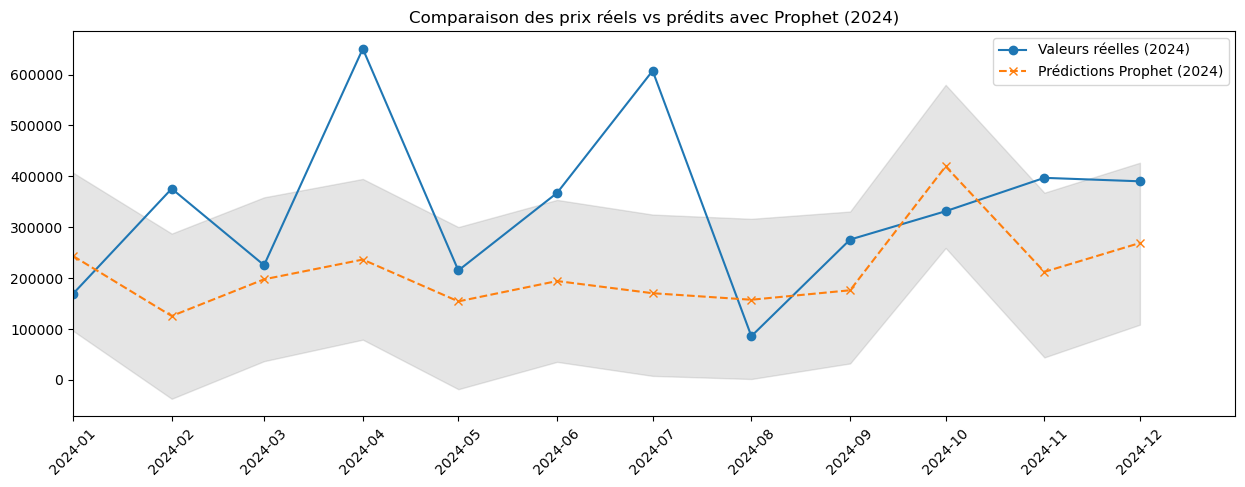

[Résultat Prophet]


,Modèle,MAE,RMSE,R2
0,Prophet,166951.021819,211556.044537,-0.774437


In [385]:
model_prophet = Prophet(**best_params)
model_prophet.fit(train_p)

future = model_prophet.make_future_dataframe(periods=12, freq='MS')
forecast = model_prophet.predict(future)

# Filtrer uniquement les prédictions de 2024
forecast_2024 = forecast[forecast["ds"].dt.year == 2024]

plt.figure(figsize=(15, 5))

# Valeurs réelles
plt.plot(test_p["ds"], test_p["y"], label="Valeurs réelles (2024)", marker="o")
plt.xlim(pd.to_datetime(["2024-01-01", "2024-12-31"]))
# Prédictions Prophet
plt.plot(forecast_2024["ds"], forecast_2024["yhat"], label="Prédictions Prophet (2024)", linestyle="dashed", marker="x")
# Intervalle de confiance
plt.fill_between(forecast_2024["ds"], forecast_2024["yhat_lower"], forecast_2024["yhat_upper"], color="gray", alpha=0.2)
plt.legend()
plt.title("Comparaison des prix réels vs prédits avec Prophet (2024)")
plt.xticks(rotation=45)
plt.show();

prophet_scores = [{
        "Modèle": 'Prophet',
        "MAE": mean_absolute_error(test_p["y"], forecast_2024["yhat"]),
        "RMSE": np.sqrt(mean_squared_error(test_p["y"], forecast_2024["yhat"])),
        "R2": r2_score(test_p["y"], forecast_2024["yhat"])
}]

df_scores = pd.DataFrame(prophet_scores)
print("[Résultat Prophet]")
display(df_scores)

<div class="alert alert-warning">
<i class="fa fa-info-circle"></i> Les modèles ARIMA et Prophet ne semblent pas être assez performant pour notre problème. Il faudrait explorer d'autres modèles en Deep Learning.
</div>